In [2]:
import wfdb
from wfdb import processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
record_name = "100"
record = wfdb.rdrecord(f"mitdb/{record_name}", sampfrom=0)  # Load the ECG signal
print(record)
# Display metadata
record.__dict__

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

In [20]:
# Extract signal data
MLII_signal = record.p_signal[:, 0]  # First lead (MLII)
V5_signal = record.p_signal[:, 1]  # Second lead (V5)
fs = record.fs  # Sampling frequency (360 Hz)
print(f"Record Name: {record_name}")
print("Total samples per lead:", record.p_signal.shape[0])
print("Number of leads:", record.p_signal.shape[1])
print(f"Sampling Frequency: {fs} Hz")
print(f"ECG Signal (Lead V5) Range: [{np.min(V5_signal)}, {np.max(V5_signal)}]")
print(f"ECG Signal (Lead II) Range: [{np.min(MLII_signal)}, {np.max(MLII_signal)}]")

Record Name: 100
Total samples per lead: 650000
Number of leads: 2
Sampling Frequency: 360 Hz
ECG Signal (Lead V5) Range: [-2.465, 1.225]
ECG Signal (Lead II) Range: [-2.715, 1.435]


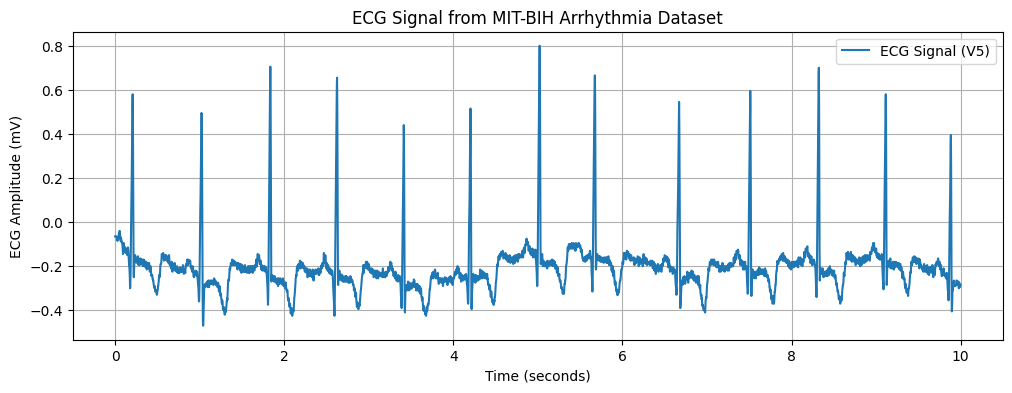

In [25]:
# Plot the first 10 seconds of V5
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(V5_signal[:3600])) / fs, V5_signal[:3600], label="ECG Signal (V5)")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude (mV)")
plt.title("ECG Signal from MIT-BIH Arrhythmia Dataset")
plt.legend()
plt.grid()
plt.show()

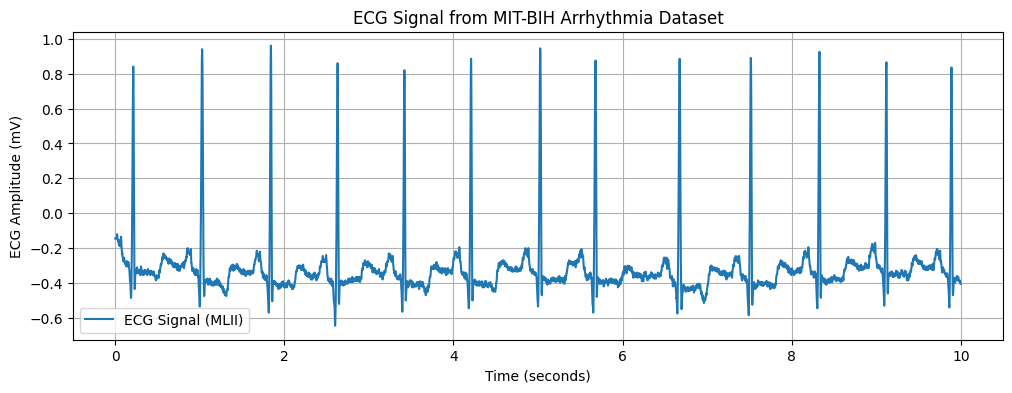

In [26]:
# Plot the first 10 seconds of MLII
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(MLII_signal[:3600])) / fs, MLII_signal[:3600], label="ECG Signal (MLII)")
plt.xlabel("Time (seconds)")
plt.ylabel("ECG Amplitude (mV)")
plt.title("ECG Signal from MIT-BIH Arrhythmia Dataset")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Read Annotations from atr file (atr -> arrhythmia labels)
annotation = wfdb.rdann(f"mitdb/{record_name}", "atr")

# Extract annotation times and labels
annotation_samples = annotation.sample
annotation_labels = annotation.symbol

# Convert sample indices to seconds
annotation_times = annotation_samples / fs

# Display first few labels
for i in range(10):
    print(f"Time: {annotation_times[i]:.2f} sec → Label: {annotation_labels[i]}")


Time: 0.05 sec → Label: +
Time: 0.21 sec → Label: N
Time: 1.03 sec → Label: N
Time: 1.84 sec → Label: N
Time: 2.63 sec → Label: N
Time: 3.42 sec → Label: N
Time: 4.21 sec → Label: N
Time: 5.03 sec → Label: N
Time: 5.68 sec → Label: A
Time: 6.67 sec → Label: N


C:\Users\hp\AppData\Local\Temp\ipykernel_16036\2754553466.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_labels["Class"], y=df_labels["Count"], palette="coolwarm")


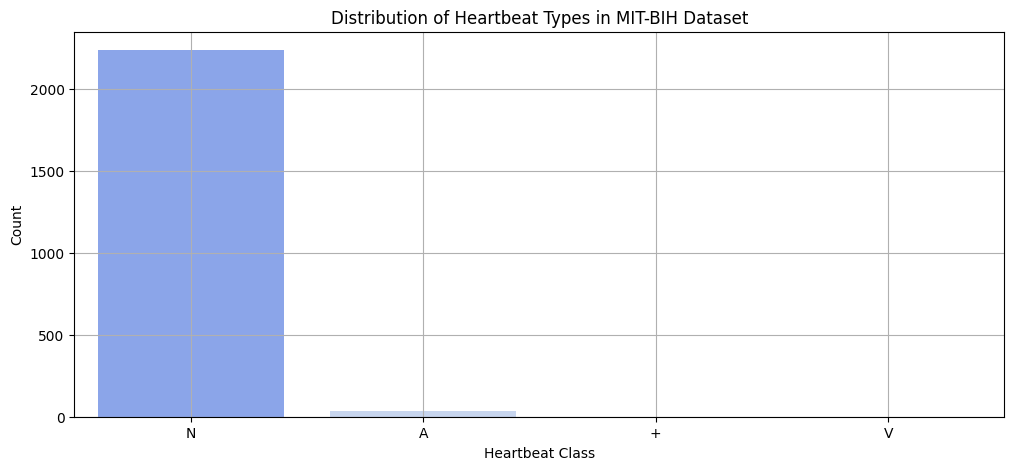

In [27]:
# Get unique heartbeat labels and their counts
from collections import Counter
import seaborn as sns

label_counts = Counter(annotation.symbol)

# Count the number of occurrences of each class
label_counts = Counter(annotation.symbol)
df_labels = pd.DataFrame(label_counts.items(), columns=["Class", "Count"])

# Sort classes by count
df_labels = df_labels.sort_values(by="Count", ascending=False)

# Plot class distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=df_labels["Class"], y=df_labels["Count"], palette="coolwarm")
plt.xlabel("Heartbeat Class")
plt.ylabel("Count")
plt.title("Distribution of Heartbeat Types in MIT-BIH Dataset")
plt.grid()
plt.show()


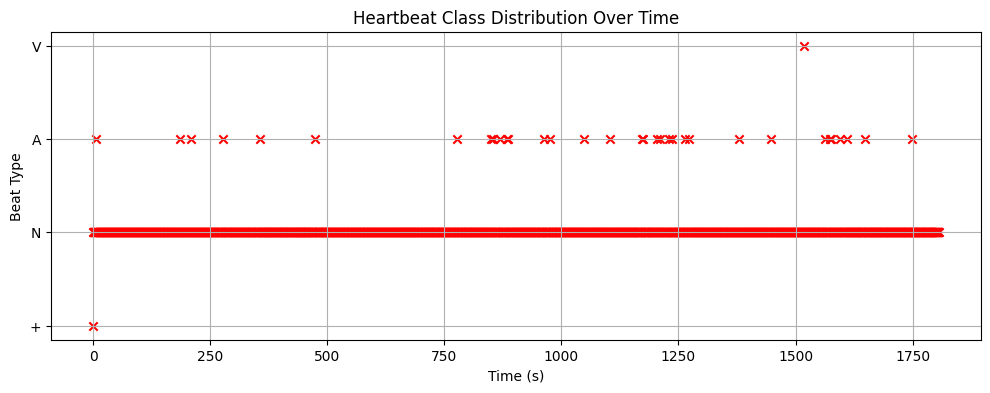

In [28]:
import numpy as np

# Convert beat annotations to time (in seconds)
time_stamps = annotation.sample / fs  # Convert sample indices to time

# Plot each beat type along the timeline
plt.figure(figsize=(12, 4))
plt.scatter(time_stamps, annotation.symbol, c="red", marker="x")
plt.xlabel("Time (s)")
plt.ylabel("Beat Type")
plt.title("Heartbeat Class Distribution Over Time")
plt.grid()
plt.show()


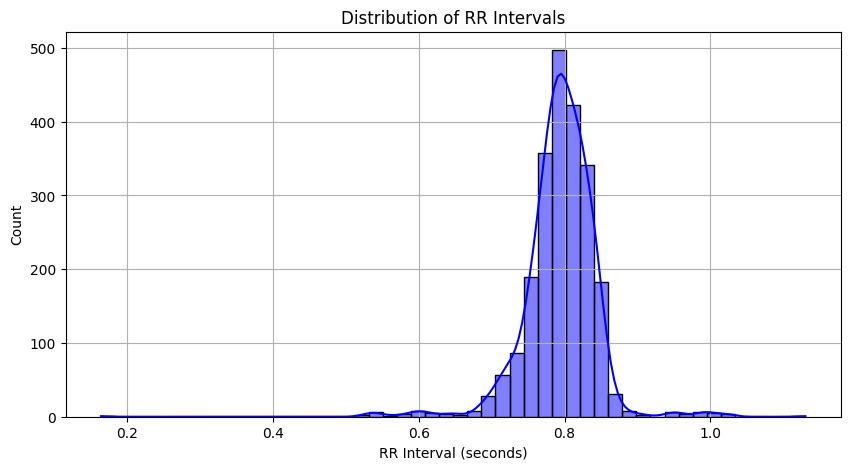

In [29]:
# Compute RR intervals (time between consecutive heartbeats)
rr_intervals = np.diff(annotation.sample) / fs  # Convert to seconds

# Plot histogram of RR intervals
plt.figure(figsize=(10, 5))
sns.histplot(rr_intervals, bins=50, kde=True, color="blue")
plt.xlabel("RR Interval (seconds)")
plt.ylabel("Count")
plt.title("Distribution of RR Intervals")
plt.grid()
plt.show()


Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


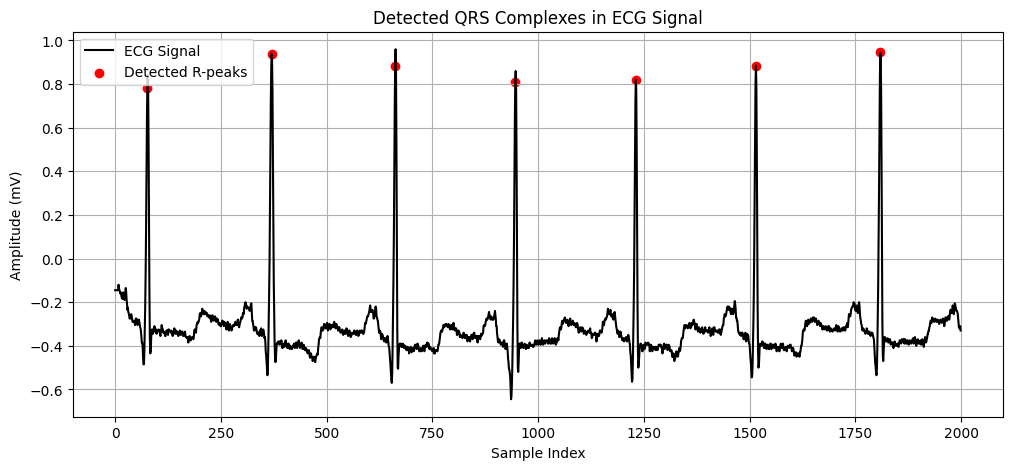

In [30]:
# Detect R-peaks using Pan-Tompkins algorithm
r_peaks = processing.xqrs_detect(sig=ecg_signal, fs=fs)

# Plot detected R-peaks
plt.figure(figsize=(12, 5))
plt.plot(ecg_signal[:2000], label="ECG Signal", color="black")
plt.scatter(r_peaks[r_peaks < 2000], ecg_signal[r_peaks[r_peaks < 2000]], color="red", label="Detected R-peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.title("Detected QRS Complexes in ECG Signal")
plt.legend()
plt.grid()
plt.show()


In [31]:
# Extract important ECG features
features = {
    "RR_intervals_mean": np.mean(rr_intervals),
    "RR_intervals_std": np.std(rr_intervals),
    "Heart Rate (bpm)": 60 / np.mean(rr_intervals),
}

# Print extracted features
print(pd.DataFrame([features]))


   RR_intervals_mean  RR_intervals_std  Heart Rate (bpm)
0           0.794316          0.050584         75.536676


In [10]:
# Compute RR intervals
rr_intervals = np.diff(annotation.sample) / fs

# Compute statistics
rr_mean = np.mean(rr_intervals)
rr_median = np.median(rr_intervals)
rr_std = np.std(rr_intervals)

print(f"Mean RR Interval: {rr_mean:.3f} sec")
print(f"Median RR Interval: {rr_median:.3f} sec")
print(f"Std Deviation: {rr_std:.3f} sec")


Mean RR Interval: 0.794 sec
Median RR Interval: 0.797 sec
Std Deviation: 0.051 sec


In [10]:
# Compute heart rate in beats per minute (BPM)
heart_rate = 60 / rr_intervals

# Plot HRV over time
plt.figure(figsize=(20, 5))
plt.plot(time_stamps[1:], heart_rate, color="purple", marker="o", markersize=2, linestyle="-")
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (bpm)")
plt.title("Heart Rate Variability Over Time")
plt.grid()
plt.show()


NameError: name 'rr_intervals' is not defined

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


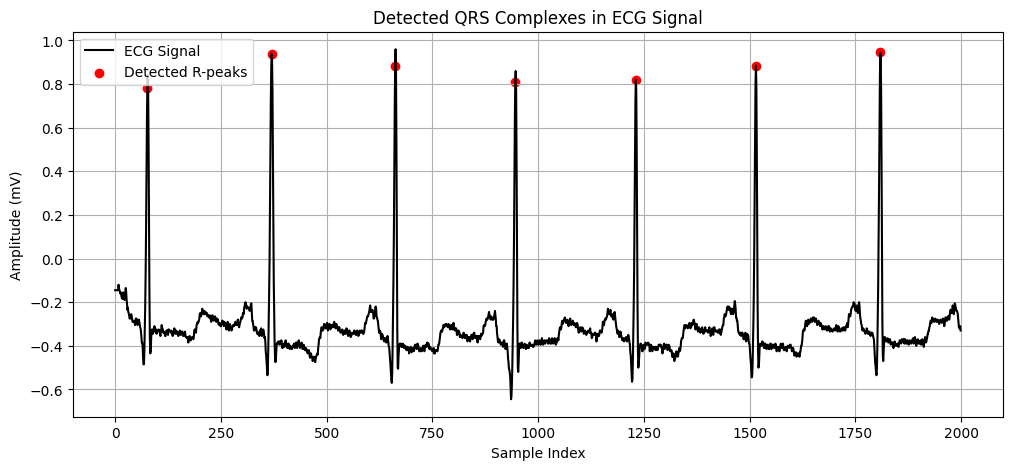

In [13]:
from wfdb import processing

# Detect R-peaks
r_peaks = processing.xqrs_detect(sig=ecg_signal, fs=fs)

# Plot ECG segment with R-peaks
plt.figure(figsize=(12, 5))
plt.plot(ecg_signal[:2000], label="ECG Signal", color="black")
plt.scatter(r_peaks[r_peaks < 2000], ecg_signal[r_peaks[r_peaks < 2000]], color="red", label="Detected R-peaks")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.title("Detected QRS Complexes in ECG Signal")
plt.legend()
plt.grid()
plt.show()

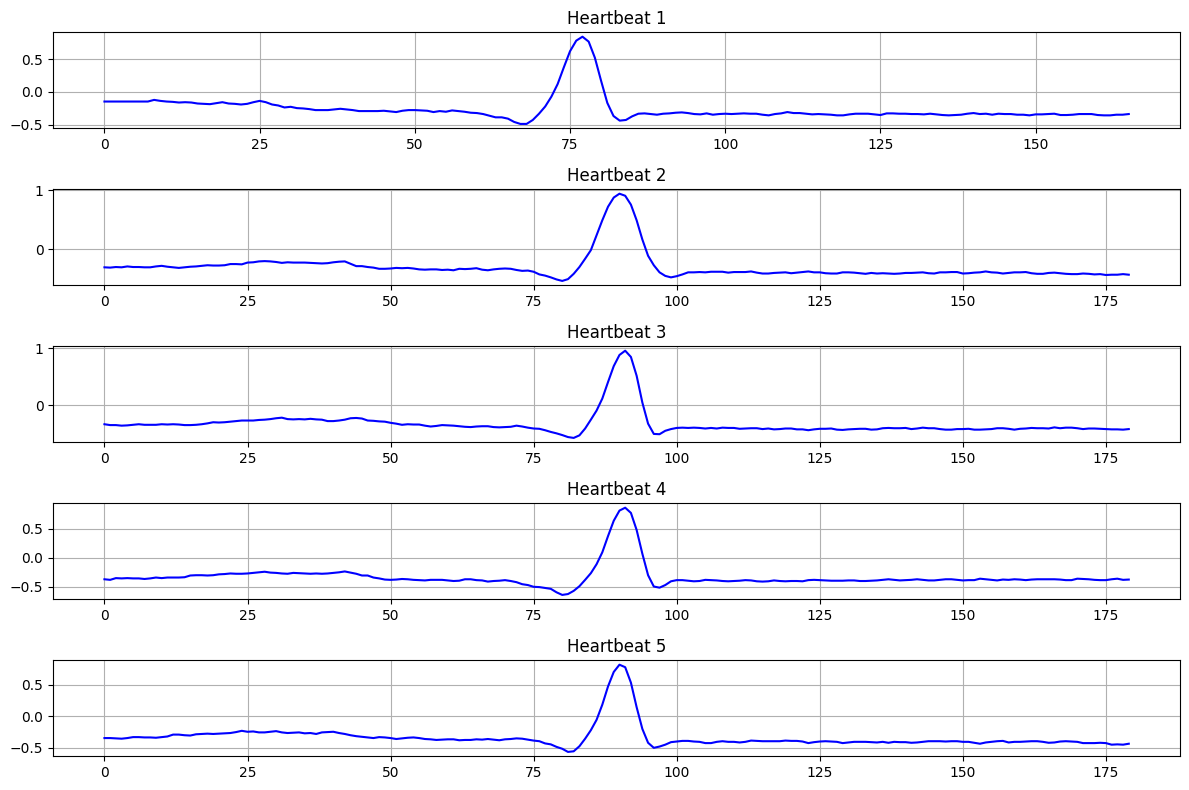

In [14]:
# Extract heartbeat segments around detected R-peaks
segment_size = int(0.5 * fs)  # 500ms window

# Extract 5 sample heartbeats
plt.figure(figsize=(12, 8))
for i, r in enumerate(r_peaks[:5]):
    start = max(0, r - segment_size // 2)
    end = min(len(ecg_signal), r + segment_size // 2)
    plt.subplot(5, 1, i+1)
    plt.plot(ecg_signal[start:end], color="blue")
    plt.title(f"Heartbeat {i+1}")
    plt.grid()

plt.tight_layout()
plt.show()Q#a

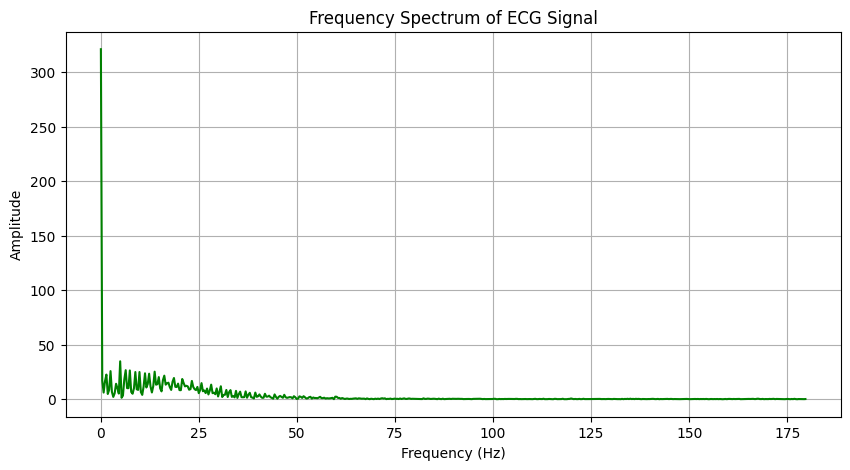

In [15]:
from scipy.fft import fft

# Compute FFT of an ECG segment
segment = ecg_signal[:1024]
freqs = np.fft.fftfreq(len(segment), d=1/fs)
fft_values = np.abs(fft(segment))

# Plot frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(freqs[:len(freqs)//2], fft_values[:len(freqs)//2], color="green")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Spectrum of ECG Signal")
plt.grid()
plt.show()


In [16]:
features = {
    "Mean RR Interval": np.mean(rr_intervals),
    "STD RR Interval": np.std(rr_intervals),
    "Median Heart Rate": np.median(heart_rate),
    "QRS Peak Amplitude": np.max(ecg_signal[r_peaks]),
}

# Convert to DataFrame for better visualization
df_features = pd.DataFrame([features])
print(df_features)


   Mean RR Interval  STD RR Interval  Median Heart Rate  QRS Peak Amplitude
0          0.794316         0.050584          75.261324               1.005
